#**Advanced Machine Learning**

##A Voting System of 3 Deep Learning Approaches for Pneumonia Detection in X-ray Images 



---


⚡Team: Nissopoulou Xenia - Ntampakis Nikos

### 1st model

######ViT

In [ ]:
# upload the kaggle.json file and proceed with the load of the data from the competition
!rm -r ~/.kaggle 
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c detect-pneumonia-spring-2022
!mkdir pneumonia_2022
!unzip detect-pneumonia-spring-2022.zip -d pneumonia_2022

In [ ]:
# installations
!pip install -U tensorflow-addons
!pip install pydicom
!pip install transformers
!pip install folium==0.2.1
!pip install -q transformers datasets
# imports
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator 
import keras
import random
import shutil
import csv
import tensorflow as tf
import pydicom as dicom
import zipfile
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from PIL import Image
import os.path
import torch
from transformers import ConvNextFeatureExtractor
from torchvision.transforms import ( Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor )
from transformers import AutoModelForImageClassification
from datasets import load_dataset
import statistics

In [ ]:
# preparation the data
num_classes = 3
input_shape = (256, 256, 3)
#Loading test images & test labels from the respective datasets
labels = pd.read_csv('/content/pneumonia_2022/labels_train.csv')
norm_labels = []
norm_images = []
norm_path=os.listdir('/content/pneumonia_2022/train_images/')
# retrieving the lables to preserve the order
for image in tqdm(norm_path):
  lbl = labels.loc[labels.file_name == image, 'class_id'].iloc[-1]
  norm_labels.append(lbl)
  image = cv2.imread('/content/pneumonia_2022/train_images/' + image)
  image = cv2.resize(image, dsize=(256,256))
  norm_images.append(image)

# converting the images into numpy arays
norm_images = np.array(norm_images)
norm_labels = np.array(norm_labels)

In [ ]:
# train-test split (80%)
X_train = norm_images[:3737,:,:]
X_test=norm_images[3737:,:,:]
y_train = norm_labels[:3737]
y_test=norm_labels[3737:]

In [ ]:
# print the x_train & x_test shapes
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (3737, 256, 256, 3) - y_train shape: (3737,)
x_test shape: (935, 256, 256, 3) - y_test shape: (935,)


In [ ]:
# adding one more axis to the test sets
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
# print with the new dimensions
print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (3737, 256, 256, 3) - y_train shape: (3737, 1)
x_test shape: (935, 256, 256, 3) - y_test shape: (935, 1)


In [ ]:
# configuration of the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
batch_size = 256
image_size = 144  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
# Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
# image augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [ ]:
# function to implement multilayer perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# class to implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 144 X 144
Patch size: 6 X 6
Patches per image: 576
Elements per patch: 108


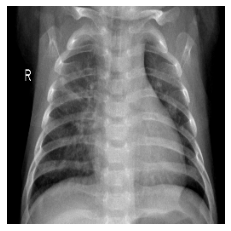

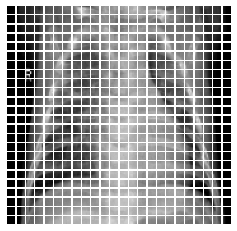

In [ ]:
# display patches for a sample image
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# implementation of the patch encoding layer
# The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim.
# In addition, it adds a learnable position embedding to the projected vector.
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
# built the ViT model
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# compile, train, and evaluate the mode
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])

    checkpoint_filepath = "/content/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True)

    history = model.fit(
        x=X_train,
        y=y_train,
        epochs= num_epochs,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_callback ]
    )

    model.load_weights(checkpoint_filepath)
    
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [ ]:
# plot accuracy scores and Loss value
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# loading target images from the respective dataset
target_images = []
file_name=[]
test_path=os.listdir('/content/pneumonia_2022/test_images/')
for test_image in tqdm(test_path):
  file_name.append(test_image)
  test_image = cv2.imread('/content/pneumonia_2022/test_images/' + test_image)
  test_image = cv2.resize(test_image, dsize=(256,256))
  target_images.append(test_image)

target_images = np.array(target_images)
Target = target_images

In [ ]:
# prediction of test images
predictions = vit_classifier.predict(Target)
predictions = predictions.argmax(axis=1)

In [ ]:
# creation of the 1st prediction dataframe
df1 = pd.DataFrame()
df1['file_name'] = file_name
df1['class_id'] = predictions



---


---



### 2nd model

######ConvNeXt

In [ ]:
# preparation of the data
labels = pd.read_csv("/content/pneumonia_2022/labels_train.csv")
labels = labels.sort_values('class_id')
class_names = list(labels.class_id.unique())
train_images = '/content/pneumonia_2022/train_images'
test_images = '/content/pneumonia_2022/test_images'
train_cat = '/train_'

#creating subfolders
for i in class_names:
  os.makedirs(os.path.join('train_', str(i)),exist_ok=True)
for c in class_names:
  for i in list(labels[labels['class_id']==c]['file_name']):
    try:
      get_image = os.path.join(train_images, str(i))
      move_image_to_cat = shutil.move(get_image, '/content/train_/'+str(c))
    except:
      continue

In [ ]:
# load data
dataset = load_dataset('imagefolder', data_dir='/content/train_')

In [ ]:
# get the pre-trained model
feature_extractor = ConvNextFeatureExtractor.from_pretrained('facebook/convnext-large-224')

In [ ]:
# image augmentation
# normalization
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std )
# transormation and convertion of the images to tensor.
transform = Compose( [ RandomResizedCrop(feature_extractor.size), RandomHorizontalFlip(), ToTensor(), normalize])

In [ ]:
def train_transforms(examples):
  examples['pixel_values'] = [transform(image.convert('RGB')) for image in examples['image']]
  return examples

processed_dataset = dataset.with_transform(train_transforms)
# get the shape of the torch
processed_dataset['train'][0]['pixel_values'].shape

torch.Size([3, 224, 224])

In [ ]:
# load the pre-trained model

model = AutoModelForImageClassification.from_pretrained('facebook/convnext-large-224', num_labels = 3, ignore_mismatched_sizes=True) 

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-large-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([3, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# use cude to run else cpu and print the architect of the model
device='cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

In [ ]:
# ConvNext
def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['label'] for example in examples])
  return {'pixel_values':pixel_values, 'labels':labels}
dataloader = DataLoader(processed_dataset['train'], collate_fn=collate_fn, batch_size=8, shuffle=True)

In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([8])


In [ ]:
torch.cuda.empty_cache()
#train the model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()
for epoch in range(10):
  print('Epoch:',epoch)
  correct = 0 
  total = 0
  for idx,batch in enumerate(tqdm(dataloader)):
    #move batch to GPU
    batch={k:v.to(device) for k,v in batch.items()}
    optimizer.zero_grad()
    #forward pass
    outputs = model(pixel_values=batch['pixel_values'], labels=batch['labels'])
    loss, logits = outputs.loss, outputs.logits
    loss.backward()
    logits = outputs.logits
    optimizer.step()
    # print('Loss:',loss.item())
    #metrics
    
    total+=batch['labels'].shape[0]
    predicted=logits.argmax(-1)
    correct+=(predicted==batch['labels']).sum().item()
    accuracy=correct/total
    if idx % 10==0:
      print(f"Loss after {idx} steps:", loss.item())
      print(f"Accuracy after {idx} steps:", accuracy)

In [ ]:
# load the test images
pred_list = []
path = "/content/pneumonia_2022/test_images"
for image in os.listdir(path):
  #ext = os.path.splitext(f)[1]
  img=Image.open(path+'/'+image)
  pixel_values=feature_extractor(img.convert('RGB'),return_tensors='pt').pixel_values
  pixel_values=pixel_values.cuda()
  with torch.no_grad():
    outputs=model(pixel_values)
    logits=outputs.logits
    prediction=logits.argmax(-1).item()
    pred_list.append(prediction)
    

In [ ]:
file_name=[]
test_path=os.listdir('/content/pneumonia_2022/test_images/')
for test_image in tqdm(test_path):
  file_name.append(test_image)

  0%|          | 0/1168 [00:00<?, ?it/s]

In [ ]:
# creation of the 2nd prediction dataframe
df2 = pd.DataFrame()
df2['file_name'] = file_name
df2['class_id'] = pred_list



---


---



### 3rd model

###### Concatenation of ResNet152V2, ResNet50V2 and Xception

In [ ]:
# loading test images & test labels from the respective datasets
labels = pd.read_csv('/content/pneumonia_2022/labels_train.csv')
norm_labels = []
norm_images = []
norm_path=os.listdir('/content/pneumonia_2022/train_images/')
for image in tqdm(norm_path):
  lbl = labels.loc[labels.file_name == image, 'class_id'].iloc[-1]
  norm_labels.append(lbl)
  image = cv2.imread('/content/pneumonia_2022/train_images/' + image)
  image = cv2.resize(image, dsize=(300,300))
  norm_images.append(image)

dct = {0 : 'no disease', 1: 'bacterial pneumonia', 2: 'viral pneumonia'}
norm_labels = [dct[k] for k in norm_labels]

norm_images = np.array(norm_images)
norm_labels = np.array(norm_labels)

  0%|          | 0/4672 [00:00<?, ?it/s]

In [ ]:
#Train-test split (80%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, norm_labels, test_size=0.10, random_state=42)

In [ ]:
# preparation of the datasets
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train)
y_test = one_hot_encoder.transform(y_test)

In [ ]:
# image Augmnentation
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=8)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)
datagen.fit(X_test)
val_gen = datagen.flow(X_test, y_test, batch_size=8)

In [ ]:
filepath = '/content/my_best_model.epochs{epoch:02d}-accuracy{val_accuracy:.2f}.tf'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1)

classes_number=3 #Number of classes
input_tensor=Input(shape=(300,300,3))
######################################################################################################
base_model1 = ResNet152V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
features1 = base_model1.output
######################################################################################################
base_model2 = ResNet50V2(weights='imagenet', include_top=False, input_tensor=input_tensor)
features2 = base_model2.output
####################################################################################################
base_model3 = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
features3 = base_model3.output
####################################################################################################
concatenated=keras.layers.concatenate([features1,features2,features3]) #Concatenate the extracted features
conv=keras.layers.Conv2D(1024, (1, 1),padding='same')(concatenated) #add the concatenated features to a convolutional layer
feature = Flatten(name='flatten')(conv)
dp = Dropout(0.5)(feature) #add dropout
preds = Dense(classes_number, activation='softmax', kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp) 
for layer in base_model1.layers :
  layer._name = layer.name + str('_1')
for layer in base_model2.layers :
  layer._name = layer.name + str('_2')
for layer in base_model3.layers :
  layer._name = layer.name + str('_3')
Concatenated_model = Model(inputs=input_tensor, outputs=preds)
#######################################################
for layer in Concatenated_model.layers:
  layer.trainable = True
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
Concatenated_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])
callbacks_list = [checkpoint]
history = Concatenated_model.fit(train_gen, epochs=35, validation_data=val_gen,callbacks=callbacks_list)  

In [ ]:

# plot Accuracy scores and Loss value
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# load best model
best_model = tf.keras.models.load_model('/content/my_best_model')

In [ ]:
# loading target images from the respective dataset
target_images = []
file_name=[]
test_path=os.listdir('/content/pneumonia_2022/test_images/')
for test_image in tqdm(test_path):
  file_name.append(test_image)
  test_image = cv2.imread('/content/pneumonia_2022/test_images/' + test_image)
  test_image = cv2.resize(test_image, dsize=(300,300))
  target_images.append(test_image)

target_images = np.array(target_images)
Target = target_images

In [ ]:
# predict on test
predictions = best_model.predict(Target)
predictions = one_hot_encoder.inverse_transform(predictions)
pred_list=np.array(predictions).flatten().tolist()

In [ ]:
# return to original labels
dct_r = {'no disease':0,'bacterial pneumonia':1,'viral pneumonia':2}
pred_labels = [dct_r[k] for k in pred_list]

In [ ]:
# creation of the 3rd prediction dataframe
df3 = pd.DataFrame()
df3['file_name'] = file_name
df3['class_id'] = pred_labels



---


---



### Voting system of the 3 models

In [ ]:
#Sort all predictions per file_name
df1=df1.sort_values("file_name")
df2=df2.sort_values("file_name")
df3=df3.sort_values("file_name")

In [ ]:
#Concat all predictions to 1 file
df_final=pd.DataFrame()
df_final["file_name"]=df1["file_name"]
df_final["class_id_1"]=df1["class_id"]
df_final["class_id_2"]=df2["class_id"]
df_final["class_id_3"]=df3["class_id"]

In [ ]:
#Vote system of the most frequent class
#In case of different prediction for the same images from all 3 models we use the prediction of our best model (ConvNeXt)
for index,row in df_final.iterrows():
  if df_final.loc[index,"class_id_1"] != df_final.loc[index,"class_id_2"] and df_final.loc[index,"class_id_2"] != df_final.loc[index,"class_id_3"] and df_final.loc[index,"class_id_1"] != df_final.loc[index,"class_id_3"]:
    df_final.loc[index,"class_id"] = df_final.loc[index,"class_id_2"]
  else:
    df_final.loc[index,"class_id"] = statistics.mode([df_final.loc[index,"class_id_1"], df_final.loc[index,"class_id_2"], df_final.loc[index,"class_id_3"]])
    

In [ ]:
#Create final dataset
sub=pd.DataFrame()
sub["file_name"]=df_final["file_name"]
sub["class_id"]=df_final["class_id"]
sub["class_id"] = sub["class_id"].astype(int)

In [ ]:
sub.to_csv("final.csv",index=False)